In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy
import datetime
from datetime import datetime, timedelta, time
from scipy import signal
import scipy.stats as stats
import pandas as pd
import os
import csv

#Marie C. McGraw
#Atmospheric  Science, University of Washington
#Updated 7-23-2019

#Test basic VRILE examination in ECMWF. Load all netCDF files in directory (ECMWF forecasts on SIPN grid) and concatenate in time
model_name = 'ecmwfsipn'
f_cast = 'reforecast'
filepath = '/home/disk/sipn/nicway/data/model/{model_name}/{fcast}/sipn_nc_agg'.format(model_name=model_name,fcast=f_cast)
filename = xr.open_mfdataset(filepath+'/*.nc',concat_dim='init_time')
print(filename)
region_names = filename.region_names
print(filename.init_time)

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


<xarray.Dataset>
Dimensions:       (ensemble: 25, fore_time: 215, init_time: 288, nregions: 15)
Coordinates:
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 215 days
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object 'panArctic' ... 'Central Arctic'
  * init_time     (init_time) datetime64[ns] 1993-01-01 ... 2016-12-01
Data variables:
    Extent        (init_time, ensemble, fore_time, nregions) float64 dask.array<shape=(288, 25, 215, 15), chunksize=(1, 25, 215, 15)>
<xarray.DataArray 'init_time' (init_time: 288)>
array(['1993-01-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-03-01T00:00:00.000000000', ..., '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 1993-01-01 1993-0

In [2]:
#Notice that "Extent" has dimensions of [init_time x ensemble x fore_time x nregions]
#time:
#init_time: forecast initialization time. 1x/month, on the first of the month
#ensemble: ensemble number (51 total)
#fore_time: forecast time. Days since init_time (up to 215 days)
#nregions: regions (0 is panArctic, 1-14 are regions)
extent = filename.Extent
init_time = filename.init_time
print(np.dtype(init_time[4].values))
print(init_time[0].values)
#Get a list of dates for the forecast days, so we know which are in summer
start_date = np.array(init_time[0].values).astype('datetime64[D]')
init_dates = pd.DatetimeIndex(np.array(init_time.values))#.astype('datetime64[D]'))
gap = init_dates[0]+timedelta(60)
print(gap.month)
forecast_time = filename.fore_time #in nanoseconds (seriously? ugh)
multiplier = 86400000000000
forecast_days = forecast_time.values #covnert from nanoseconds
forecast_days = forecast_days/multiplier
forecast_dates = start_date
#print(forecast_dates)
for idate in np.arange(0,len(forecast_days)):
    idelta = start_date + np.timedelta64(forecast_days[idate]*multiplier,'D')
    forecast_dates = np.append(forecast_dates,idelta)

#print(forecast_dates)
#TIME = pd.DatetimeIndex(forecast_dates)

#We want to focus on JJAS
mon_sel = [6,7,8,9]  #looking at JJAS
mon_sel_str = 'JJAS'
day_sep = 2
region_sel = 0
extent_test = extent[:,:,:,1]
print(extent_test.shape)


datetime64[ns]
1993-01-01T00:00:00.000000000
3
(288, 25, 215)


In [3]:
##Create a climatology--remove average Jan 1 from all Jan 1, etc
TIME_all = np.array([])
#print(TIME_all)
for i in np.arange(0,len(init_time)):
    start_date_i = np.array(init_time[i].values).astype('datetime64[D]')
    forecast_dates_i = time(0,0)
    for jdate in np.arange(0,len(forecast_days)):
        idelta = start_date_i + np.timedelta64(forecast_days[jdate]*multiplier,'D')
        forecast_dates_i = np.append(forecast_dates_i,idelta)
        
    TIME_all = np.append(TIME_all,forecast_dates_i)
#print(forecast_dates_i)
print(TIME_all[0],TIME_all[216],TIME_all[432])
#print(np.arange(0,288*216,216))
TIME_adj = np.delete(TIME_all,np.arange(0,288*216,216))
TIME = pd.DatetimeIndex(TIME_adj)
months = TIME.month
days = TIME.day
year = TIME.year
#TEST = np.append(TIME_all,forecast_dates_i)
#Make a test plot for first initialization date in pan Arctic region. We'll show all ensemble members and all forecast dates
print(extent.shape)


00:00:00 00:00:00 00:00:00
(288, 25, 215, 15)


(288, 215)


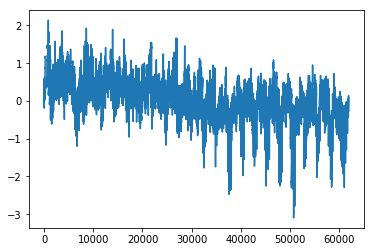

In [4]:
#Remove seasonal cycle from Extent
SIE_seas_cyc = np.array([])
N = len(TIME)
day_sep = 2
ens_sel = 5
region_sel = 0
region_name = region_names[region_sel]
#print(TIME[100].month)
SIE_test = np.squeeze(extent[:,ens_sel,:,region_sel])
print(SIE_test.shape)
SIE_test_rsx = SIE_test.values.reshape((len(TIME),))
#SIE_test_rs2 = SIE_test_rsx.reshape((len(init_time),len(forecast_time)))
#xxx = SIE_test_rs2 - SIE_test
#print(xxx.values)
SIE_test_rs = SIE_test_rsx - np.nanmean(SIE_test_rsx)
#Remove Seasonal Cycle of SIE
SIE_rm_seas = np.array([])
for iseas in np.arange(0,len(SIE_test_rs)):
    idate = TIME[iseas]
    ind_sel = np.where((TIME.month==idate.month) & ((idate.day-day_sep<=TIME.day) & (TIME.day<=idate.day+day_sep)))
    SIE_rm_seas = np.append(SIE_rm_seas,(SIE_test_rs[iseas,] - np.nanmean(SIE_test_rs[ind_sel,])))
gap_days = 60 #forecast for up to 60 days
plt.plot(SIE_rm_seas)
SIE_anom_rs = SIE_rm_seas.reshape((len(init_time),len(forecast_time)))
#fart = np.isin(init_time[0]+timedelta(gap_days).month,mon_sel)
fart = init_dates[4]
#print(fart)
#fart2 = fart + timedelta(np.arange(0,60))
fart3 = pd.date_range(init_dates[4],periods=60)
#print(fart3.month)
#print(any(np.isin(fart3.month,mon_sel)))
xx = np.where(np.isin(fart3.month,mon_sel))
#print(fart3[xx])
#fart2 = np.isin(fart.month)

In [5]:
#fart = np.stack((extent[:,0,1,0],extent[:,1,1,0]),axis=1)
#print(fart.shape)
print(extent.shape[1])
print('ensemble no {ens}'.format(ens=extent.shape[1]))
no_days = 5
i_ens = 1
fname = '/home/disk/sipn/mcmcgraw/figures/VRILE/Zhou_Wang_replicate/figures_results/'\
'MODEL_{modelname}_SIC_{no_days}day_change_ensemble{ens_no}_{seas}_{region}'.format(modelname=model_name,no_days=no_days,ens_no=i_ens+1,seas=mon_sel_str,region=region_names[region_sel].values)

25
ensemble no 25


Text(0.5, 1.0, 'JJAS SIC anomalies, ECMWF reforecast, panArctic')

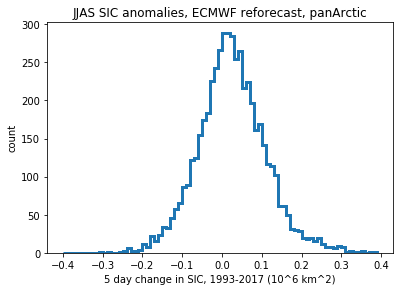

In [6]:
SIE_delta_ALL = np.array([])
for i_init in np.arange(0,len(init_time)):
    SIE_i_init = SIE_anom_rs[i_init,:]
    day_init = init_dates[i_init]
    forecast_range = pd.date_range(day_init,periods=gap_days)
    if(any(np.isin(forecast_range.month,mon_sel)) == True):
        sel_ind = np.where(np.isin(forecast_range.month,mon_sel))
        SIE_sel = SIE_i_init[sel_ind]
        dates_sel = forecast_range[sel_ind] #selected dates
        SIE_delta = np.array([])
        for idelta in np.arange(day_sep,len(SIE_sel)-day_sep):
            SIE_idelta = SIE_sel[idelta+day_sep] - SIE_sel[idelta-day_sep]
            SIE_delta = np.append(SIE_delta,SIE_idelta)
            
        SIE_delta_ALL = np.append(SIE_delta_ALL,SIE_delta)
        
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2.hist(SIE_delta_ALL,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=False,linewidth=3)
ax2.set_xlabel('{no_days} day change in SIC, 1993-2017 (10^6 km^2)'.format(no_days=2*day_sep+1))
ax2.set_ylabel('count')
ax2.set_title('{seas} SIC anomalies, ECMWF reforecast, {region_name}'.format(seas=mon_sel_str,region_name=region_names[region_sel].values))            

(25, 215)


Text(0.5, 1.0, 'EMCWF sea ice extent deviations from ensemble mean (Initialized: 1993-05-01T00:00:00.000000000)')

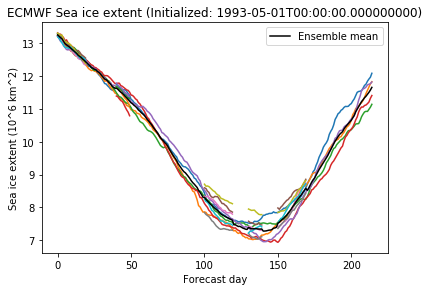

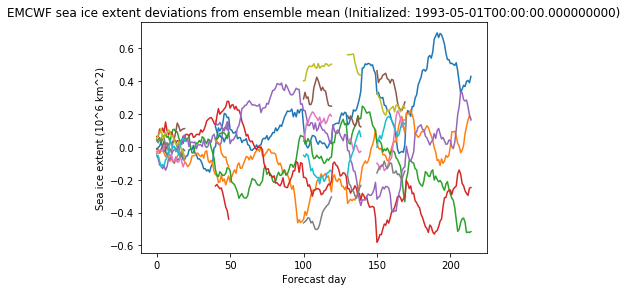

In [7]:
init_select = 4
SIE_test = np.squeeze(extent[init_select,:,:,region_sel])
print(SIE_test.shape)
SIE_ensemble_mean = np.nanmean(SIE_test,axis=0) #ensemble mean
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(np.transpose(SIE_test.values))
siem = ax1.plot(SIE_ensemble_mean,'k',label='ensemble mean')
ax1.set_xlabel('Forecast day')
ax1.set_ylabel('Sea ice extent (10^6 km^2)')
ax1.set_title('ECMWF Sea ice extent (Initialized: {fore_init})'.format(fore_init=init_time[init_select].values))
ax1.legend(siem,['Ensemble mean'])

#Create deviations from ensemble mean
SIE_anom = SIE_test - SIE_ensemble_mean
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2.plot(np.transpose(SIE_anom.values))
ax2.set_xlabel('Forecast day')
ax2.set_ylabel('Sea ice extent (10^6 km^2)')
ax2.set_title('EMCWF sea ice extent deviations from ensemble mean (Initialized: {fore_init})'.format(fore_init=init_time[init_select].values))

(25, 215)


Text(0.5, 1.0, 'ECMWF sea ice extent deviations from time mean(Initialized: 1993-05-01T00:00:00.000000000)')

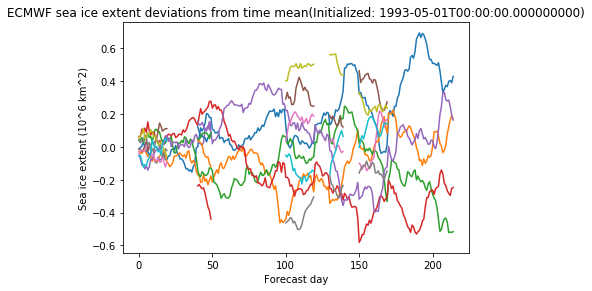

In [8]:
#Create deviations from time-mean
SIE_time_anom = SIE_test - np.nanmean(SIE_test,axis=0)
print(SIE_time_anom.shape)
fig3 = plt.figure()
ax3 = fig3.add_axes([0.1,0.1,0.8,0.8])
ax3.plot(np.transpose(SIE_time_anom.values))
ax3.set_xlabel('Forecast day')
ax3.set_ylabel('Sea ice extent (10^6 km^2)')
ax3.set_title('ECMWF sea ice extent deviations from time mean(Initialized: {fore_init})'.format(fore_init=init_time[init_select].values))

In [9]:
#Calculate change in SIC
SIC_delta = np.array([])
day_sep = 2 #number of days before/after for change
for idelta in np.arange(day_sep,SIE_time_anom.shape[1]-day_sep):
    sic_idelta = SIE_time_anom[:,idelta+day_sep] - SIE_time_anom[:,idelta-day_sep]
    SIC_delta = np.append(SIC_delta,sic_idelta)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  1.,  1.,  6.,  0.,  1.,  7.,  8.,  9.,  8.,
         9., 19., 20., 19., 35., 44., 46., 49., 53., 65., 82., 76., 74.,
        75., 83., 56., 63., 65., 57., 58., 50., 39., 27., 26., 16., 19.,
        16., 12., 11., 11.,  7.,  6.,  5.,  4.,  0.,  2.,  3.,  0.,  4.,
         3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([-4.00000000e-01, -3.90000000e-01, -3.80000000e-01, -3.70000000e-01,
        -3.60000000e-01, -3.50000000e-01, -3.40000000e-01, -3.30000000e-01,
        -3.20000000e-01, -3.10000000e-01, -3.00000000e-01, -2.90000000e-01,
        -2.80000000e-01, -2.70000000e-01, -2.60000000e-01, -2.50000000e-01,
        -2.40000000e-01, -2.30000000e-01, -2.20000000e-01, -2.10000000e-01,
        -2.00000000e-01, -1.90000000e-01, -1.80000000e-01, -1.70000000e-01,
        -1.60000000e-01, -1.50000000e-01, -1.40000000e-01, -1.30000000e-01,
        -1.2000

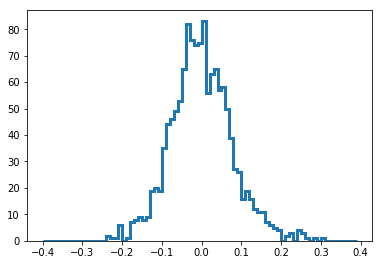

In [10]:
fig4 = plt.figure()
ax4 = fig4.add_axes([0.1,0.1,0.8,0.8])
ax4.hist(SIC_delta,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=False,linewidth=3)

In [12]:
detrend_stat = 'NO_dt'
region_name_fn = region_names[region_sel].values
#print(test)
NSIDC_filename = '/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/OBS/NSIDC_SIE_delta_{nodays}day_' \
'change_{region}_{seas}_{detrend_stat}.txt'.format(nodays=no_days,region=region_name_fn,seas=mon_sel_str,detrend_stat=detrend_stat)
print(NSIDC_filename)
NSIDC_SIE = np.genfromtxt(NSIDC_filename,unpack='True')

/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/OBS/NSIDC_SIE_delta_5day_change_panArctic_JJAS_NO_dt.txt


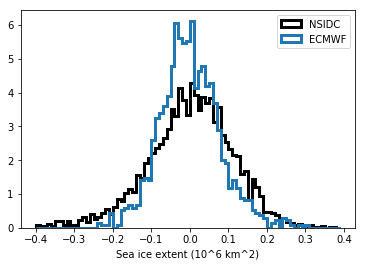

In [13]:
#weights_NSIDC = np.ones_like(NSIDC_SIE)/float(len(NSIDC_SIE))
#weights_model = np.ones_like(SIC_delta)/float(len(SIC_delta))
plt.figure()
#plt.hist(NSIDC_SIE,weights=weights_NSIDC,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=False,linewidth=3,color='k')
#plt.hist(SIC_delta,weights=weights_model,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=False,linewidth=3)
plt.hist(NSIDC_SIE,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=True,linewidth=3,color='k')
plt.hist(SIC_delta,bins=np.arange(-0.4,0.4,0.01),histtype=u'step',density=True,linewidth=3)
plt.xlabel('Sea ice extent (10^6 km^2)')
plt.legend(['NSIDC','ECMWF'])


In [14]:
#Percentiles and moments for NSIDC and ECMWF
pctile_vals = [1,5,25,50,75,95,99]
NSIDC_pctiles = np.percentile(NSIDC_SIE,pctile_vals)
print(NSIDC_pctiles)
model_pctiles = np.nanpercentile(SIC_delta,pctile_vals)
print(model_pctiles)

[-0.32218322 -0.19139422 -0.06538136  0.00594592  0.07334021  0.17221196
  0.24611098]
[-0.1745303  -0.12074057 -0.04950978 -0.00353746  0.04661477  0.13201779
  0.21569425]


In [15]:
OBS_mean = np.nanmean(NSIDC_SIE)
OBS_var = np.nanvar(NSIDC_SIE)
OBS_skew = stats.skew(NSIDC_SIE) #skewness: asymmetry. Negative skewness = bigger negative tail
OBS_kurt = stats.kurtosis(NSIDC_SIE) #kurtosis: deviation from normal. positive kurtosis = heavier tails than normal
print('MEAN: ',OBS_mean,'VAR: ',OBS_var,'SKEW: ',OBS_skew,'KURT: ',OBS_kurt)
OBS_stats = [OBS_mean,OBS_var,OBS_skew,OBS_kurt]
print(OBS_stats)

MEAN:  -0.00011096564754098431 VAR:  0.012778638849267662 SKEW:  -0.4020742969461601 KURT:  1.09189714110674
[-0.00011096564754098431, 0.012778638849267662, -0.4020742969461601, 1.09189714110674]


In [16]:
MODEL_mean = np.nanmean(SIC_delta)
MODEL_var = np.nanvar(SIC_delta)
MODEL_skewx = stats.skew(SIC_delta,nan_policy='omit') #skewness: asymmetry. Negative skewness = bigger negative tail
MODEL_skew = MODEL_skewx.data.astype('float64')
MODEL_kurt = stats.kurtosis(SIC_delta,nan_policy='omit') #kurtosis: deviation from normal. positive kurtosis = heavier tails than normal
print('MEAN: ',MODEL_mean,'VAR: ',MODEL_var,'SKEW: ',MODEL_skew,
      'KURT: ',MODEL_kurt)
MODEL_stats = np.ma.append(MODEL_mean,MODEL_var)
MODEL_stats = np.ma.append(MODEL_stats,MODEL_skew)
MODEL_stats = np.ma.append(MODEL_stats,MODEL_kurt)
MODEL_stats = list(MODEL_stats)
print(MODEL_stats)

MEAN:  -0.0005417611349408457 VAR:  0.005953118891787129 SKEW:  0.2970414873316363 KURT:  0.6996749625244796
[-0.0005417611349408457, 0.005953118891787129, 0.2970414873316363, 0.6996749625244796]


In [31]:
#Save statistics to text file
fpath_save = '/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/MODELS/{model_name}/{forecast}/'.format(model_name=model_name,forecast=f_cast)
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)
    
fname_stats = fpath_save+'STATS_SIC_{no_days}day_change_{model_name}_vs_OBS_{region}_{season}.csv'.format(no_days=no_days,model_name=model_name,region=region_name_fn,season=mon_sel_str)
print(fname_stats)
fname_pctiles = fpath_save+'PCTILES_SIC_{no_days}day_change_{model_name}_vs_OBS_{region}_{season}.csv'.format(no_days=no_days,model_name=model_name,region=region_name_fn,season=mon_sel_str)

#with open(fname_stats,'w') as fstats:
#    filewriter = csv.writer(fstats,delimiter=',',quotechar='|',quoting=csv.QUOTE_MINIMAL)
#    filewriter.writerow([' ','MEAN','VARIANCE','SKEWNESS','KURTOSIS'])
#   filewriter.writerow(['OBS',OBS_stats])
#    filewriter.writerow(['MODEL',MODEL_stats])
#    fstats.close()
print(fpath_save)
print(MODEL_stats)
fart = [OBS_stats, MODEL_stats]
fartpd = pd.DataFrame(fart)
print(fartpd)
#fartpd.columns(['MEAN','VARIANCE','SKEW','KURTOSIS'])
fartpd.to_csv(fpath_save+'TEST_PANDAS_OUT.csv',sep=',',header=['MEAN','VAR','SKEW','KURT'])

/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/MODELS/ecmwfsipn/reforecast/STATS_SIC_5day_change_ecmwfsipn_vs_OBS_panArctic_JJAS.csv
/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/MODELS/ecmwfsipn/reforecast/
[-0.0005417611349408457, 0.005953118891787129, 0.2970414873316363, 0.6996749625244796]
          0         1         2         3
0 -0.000111  0.012779 -0.402074  1.091897
1 -0.000542  0.005953  0.297041  0.699675


In [18]:
with open(fname_pctiles,'w') as fpctl:
    filewriter2 = csv.writer(fpctl,delimiter=',',quotechar='|',quoting=csv.QUOTE_MINIMAL)
    filewriter2.writerow([' ',pctile_vals])
    filewriter2.writerow(['OBS',list(NSIDC_pctiles)])
    filewriter2.writerow(['MODEL',list(model_pctiles)])
    fpctl.close()

 -0.12074056878356815
